# **Auto-Encoders:**
###### Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

### Imports

In [1]:
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt

### Loading MNIST-Digits Dataset

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

### Example of Dataset

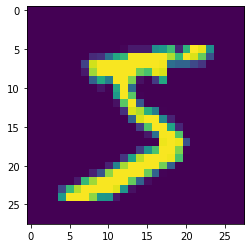

In [4]:
plt.imshow(x_train[0])

### Preparing the dataset

1.   Normalising the images
2.   Adding extra dimension to the images.



In [5]:
x_train = tf.cast(x_train, dtype = tf.float32)/255.0
x_test = tf.cast(x_test, dtype=tf.float32)/255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

### Creating the training dataset by adding noise to the images and clipping the values out of 0 and 1.

In [6]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


In [7]:
print(x_train_noisy.shape)

(60000, 28, 28, 1)


### Plotting some example from training and testing data.

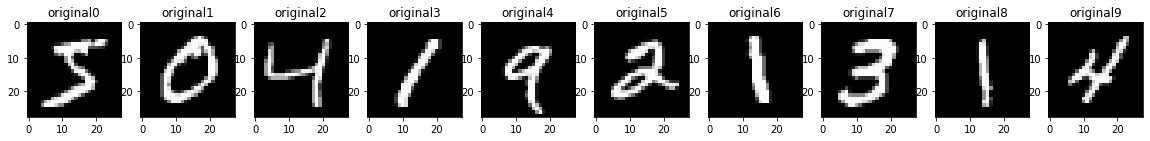

In [8]:
n = 10
plt.figure(figsize=(20, 2))
plt.title("Training data")
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original" + str(i))
    plt.imshow(tf.squeeze(x_train[i]))
    plt.gray()
plt.show()


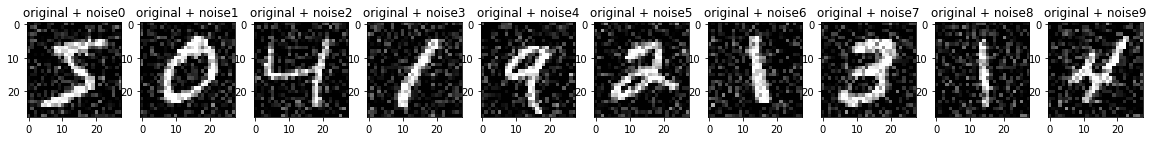

In [9]:
n = 10
plt.figure(figsize=(20, 2))
plt.title("Training data")
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise" + str(i))
    plt.imshow(tf.squeeze(x_train_noisy[i]))
    plt.gray()
plt.show()


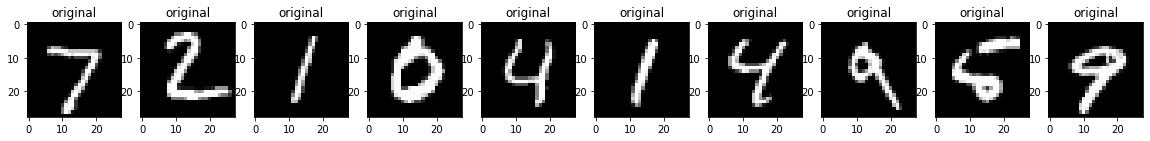

In [10]:
n = 10
plt.figure(figsize=(20, 2))
plt.title("Test Data")
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()


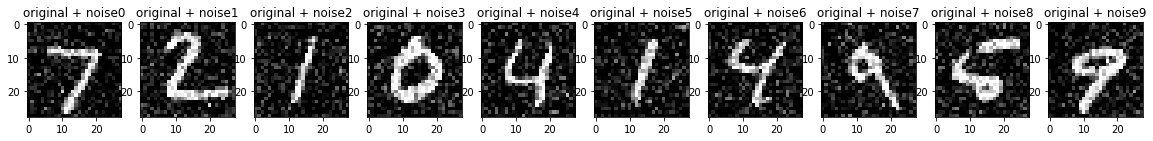

In [11]:
n = 10
plt.figure(figsize=(20, 2))
plt.title("Testing data")
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise" + str(i))
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()


### Defining a Denoising model class

In [12]:
class Denoise(keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder_model = keras.models.Sequential([
            keras.Input(shape=(28, 28, 1)),
            keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same'),
            keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same'),
        ])

        self.decoder_model = keras.models.Sequential([
            keras.layers.Conv2DTranspose(32, (3, 3), activation='elu', padding='same'),
            keras.layers.Conv2DTranspose(64, (3, 3), activation='elu', padding='same'),
            keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
            keras.layers.Reshape((28, 28, 1)),
        ])

    def call(self, x):
        encoded = self.encoder_model(x)
        decoded = self.decoder_model(encoded)
        return (decoded)


### Setting a denoise model

In [13]:
denoise = Denoise()
early_stopping = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
denoise.compile(optimizer='adam', loss =keras.losses.MeanSquaredError(), metrics=['accuracy'])
denoise.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=100, callbacks=[early_stopping], shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 29s 12ms/step - loss: 0.0040 - accuracy: 0.8152 - val_loss: 0.0027 - val_accuracy: 0.8145
Epoch 2/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0025 - accuracy: 0.8155 - val_loss: 0.0024 - val_accuracy: 0.8145
Epoch 3/100
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0024 - accuracy: 0.8155 - val_loss: 0.0024 - val_accuracy: 0.8145
Epoch 4/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0024 - accuracy: 0.8155 - val_loss: 0.0023 - val_accuracy: 0.8145
Epoch 5/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0023 - accuracy: 0.8155 - val_loss: 0.0023 - val_accuracy: 0.8145
Epoch 6/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0023 - accuracy: 0.8155 - val_loss: 0.0023 - val_accuracy: 0.8145
Epoch 7/100
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0023 - accuracy: 0.8155 - val_loss: 0.0023 

<Figure size 864x504 with 0 Axes>

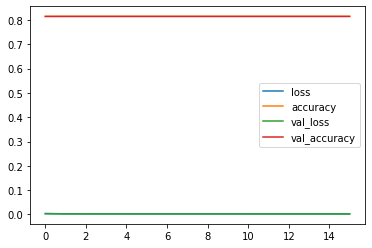

In [14]:
import pandas as pd 
plt.figure(figsize=(12, 7))
pd.DataFrame(denoise.history.history).plot()

### Making prediction on random image

In [17]:
random_image = 55
image = x_train_noisy[random_image][tf.newaxis, ...]
prediction = denoise.predict(image)

In [18]:
prediction.shape

(1, 28, 28, 1)

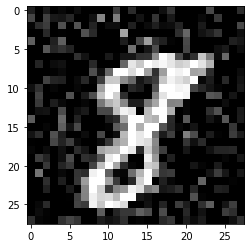

In [19]:
plt.imshow(tf.squeeze(x_train_noisy[random_image]))

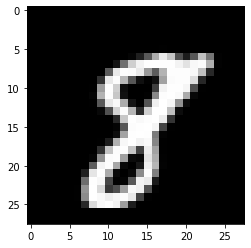

In [20]:
plt.imshow(tf.squeeze(prediction))

### Denoising Model 2: Deleting the structure of the image

In [21]:
class Denoise_2(keras.Model):
    def __init__(self):
        super(Denoise_2, self).__init__()
        self.encoder_model = keras.models.Sequential([
            keras.Input(shape=(28, 28, 1)),
            keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same'),
            keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same'),
            keras.layers.Flatten(),
        ])

        self.decoder_model = keras.models.Sequential([
            keras.layers.Dense(64, activation = 'elu'),
            keras.layers.Dense(128, activation = 'elu'),
            keras.layers.Dense(784, activation = 'sigmoid'),
            keras.layers.Reshape((28, 28, 1)),
        ])

    def call(self, x):
        encoded = self.encoder_model(x)
        decoded = self.decoder_model(encoded)
        return (decoded)


In [22]:
denoise_2 = Denoise_2()
early_stopping = keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
denoise_2.compile(optimizer='adam', loss =keras.losses.MeanSquaredError(), metrics=['accuracy'])
denoise_2.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=100, callbacks=[early_stopping], shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0177 - accuracy: 0.8109 - val_loss: 0.0118 - val_accuracy: 0.8130
Epoch 2/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0114 - accuracy: 0.8137 - val_loss: 0.0101 - val_accuracy: 0.8130
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0101 - accuracy: 0.8140 - val_loss: 0.0098 - val_accuracy: 0.8132
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0096 - accuracy: 0.8142 - val_loss: 0.0090 - val_accuracy: 0.8134
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - accuracy: 0.8143 - val_loss: 0.0087 - val_accuracy: 0.8133
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0087 - accuracy: 0.8144 - val_loss: 0.0083 - val_accuracy: 0.8135
Epoch 7/100
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0083 - accuracy: 0.8145 - val_loss: 0.0080 - val_ac

<Figure size 864x504 with 0 Axes>

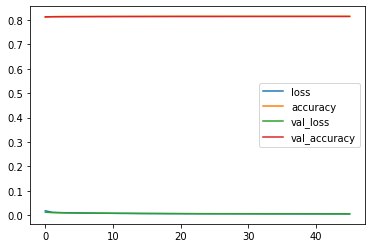

In [23]:
import pandas as pd 
plt.figure(figsize=(12, 7))
pd.DataFrame(denoise_2.history.history).plot()

### Making prediction

In [24]:
random_image = 55
image = x_train_noisy[random_image][tf.newaxis, ...]
prediction = denoise_2.predict(image)

In [25]:
prediction.shape

(1, 28, 28, 1)

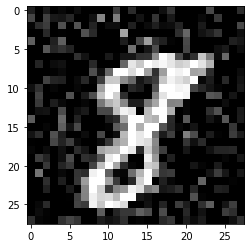

In [26]:
plt.imshow(tf.squeeze(x_train_noisy[random_image]))

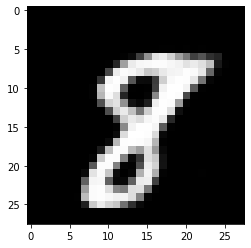

In [27]:
plt.imshow(tf.squeeze(prediction))